In [1]:
import os
os.getcwd()

'E:\\researches\\MusicVAE'

In [2]:
os.chdir('E:\\researches\\MusicVAE\\src')

In [3]:
from src.params import *
from src.model import VariationalAutoencoder
import matplotlib.pyplot as plt
from src.midi_builder_new import MidiBuilderNew
from src.new_model import VAECell

In [4]:
m_key_count

3

In [5]:
from data_utils import MidiDataset, BarTransform
from torch.autograd import Variable #deprecated!!!

In [6]:
builder = MidiBuilderNew()

In [7]:
''' 
Create model and load state dict from path
'''
def loadModel(path):
    model = VAECell(latent_features)
    model.load_state_dict(torch.load(path, map_location=device))
    model.eval()

    return model

In [8]:
transform = BarTransform(bars=totalbars, note_count=NUM_PITCHES)
midi_dataset = MidiDataset(csv_file='../piano_rolls_a_small_fraction.csv', transform = transform)
dataset_size = len(midi_dataset)           #number of musics on dataset
test_size = int(test_split * dataset_size) #test size length
train_size = dataset_size - test_size      #train data length
train_dataset, test_dataset = random_split(midi_dataset, [train_size, test_size])
test_loader = DataLoader(test_dataset, shuffle=shuffle, batch_size=batch_size, num_workers=1)#, sampler=test_sampler)


In [9]:
model = loadModel('../records/net_Apr_16_3_chord.pt')
model = model.to(device)

Use attention type dot


In [10]:
x = next(iter(test_loader))
x = Variable(x['piano_rolls'].type('torch.FloatTensor'))

x = x.to(device)

#model.set_scheduled_sampling(1.)  # Please use teacher forcing for validations
outputs = model(x)

In [11]:
x_hat = outputs['multi_notes']
x = x.to("cpu")
x_hat = x_hat.to("cpu")

In [12]:
x_hat.shape

torch.Size([32, 256, 3, 61])

In [13]:
multi_notes_np = x_hat.detach().numpy()

In [14]:
x_hat[0,0,0,:]

tensor([8.1859e-03, 2.5362e-02, 1.1639e-02, 3.9184e-02, 1.1827e-02, 2.6658e-02,
        4.8236e-02, 1.2023e-02, 3.7479e-02, 3.9916e-02, 4.0740e-02, 2.0074e-02,
        2.9393e-02, 5.2379e-02, 2.2101e-02, 5.4611e-02, 1.6022e-02, 3.3283e-02,
        6.4144e-02, 1.7216e-02, 4.5885e-02, 3.1982e-02, 4.0009e-02, 2.3581e-02,
        3.0527e-02, 5.1252e-02, 2.3545e-02, 4.3597e-02, 9.1707e-03, 1.8190e-02,
        1.9191e-02, 5.7433e-03, 1.5473e-02, 4.8730e-03, 5.0705e-03, 2.3276e-03,
        1.9471e-03, 3.8451e-03, 9.9191e-04, 2.6535e-03, 4.4975e-04, 9.1177e-04,
        5.0643e-04, 2.5555e-04, 1.1824e-03, 3.3792e-04, 3.6354e-04, 2.9567e-04,
        3.4539e-04, 4.3639e-04, 2.1280e-04, 3.2985e-04, 1.4473e-04, 1.7377e-04,
        1.4836e-04, 6.2894e-05, 9.7018e-05, 1.2150e-04, 8.5372e-05, 1.4618e-04,
        3.0675e-03], grad_fn=<SliceBackward>)

In [15]:
seq = multi_notes_np[0]
midi_out = np.zeros((seq.shape[0],seq.shape[2]))
print(midi_out.shape)
for j in range(3):
    x_j_np = seq[:, j, :]
    row_maxes = x_j_np.max(axis=1).reshape(-1, 1)
    midi_out_j = np.where(x_j_np == row_maxes, 1, 0)
    midi_out += midi_out_j

(256, 61)


In [19]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

In [16]:
x_hat.shape

torch.Size([32, 256, 3, 61])

In [24]:
def showReconstructionsMultiNotes(multi_notes : torch.Tensor, x : torch.Tensor):
    '''
    :param multi_notes:  reconstructed multinotes
    :param x: original notes
    :return:
    '''
    multi_notes_np = x_hat.detach().numpy()


    for i, seq in enumerate(multi_notes_np):
        midi_out = np.zeros((seq.shape[0],seq.shape[2]))
        #print(midi_out.shape)
        for j in range(m_key_count):
            x_j_np = seq[:, j, :]
            row_maxes = x_j_np.max(axis=1).reshape(-1, 1)
            midi_out_j = np.where(x_j_np == row_maxes, 1, 0)
            midi_out += midi_out_j
        
        midi_out = midi_out.clip(0, 1)
        if np.sum(midi_out[:, :-1]) == 0:
            print("Midi: {} is all silent".format(i))
            continue
        
        midi = builder.midi_from_piano_roll(midi_out[:,:-1]) # Select all notes but the silent one
        plt.figure(figsize=(10, 3))
        plt.title("Midi {}".format(i))

        builder.plot_midi(midi)
        plt.savefig("../midi/img_midi_{}.png".format(i))

        midi.write('../midi/{}.mid'.format(i))
        
    exit()
    # Compare to originals
    x_np = x.detach().numpy()
    
    
    for i, seq in enumerate(x_np):
        midi_out = seq

        if np.all(midi_out[:, -1]):
            print("Midi: {} is all silent".format(i))
            continue

        midi = builder.midi_from_piano_roll(midi_out[:, :-1])  # Select all notes but the silent one
        plt.figure(figsize=(10, 3))
        plt.title("Orig Midi {}".format(i))

        builder.plot_midi(midi)
        plt.savefig("../midi/img_midi_{}_orig.png".format(i))

        midi.write('../midi/{}_orig.mid'.format(i))

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


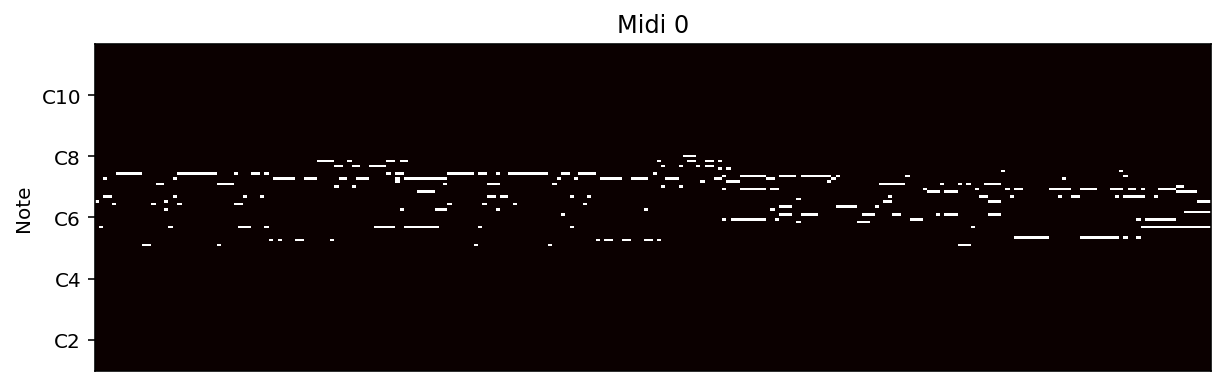

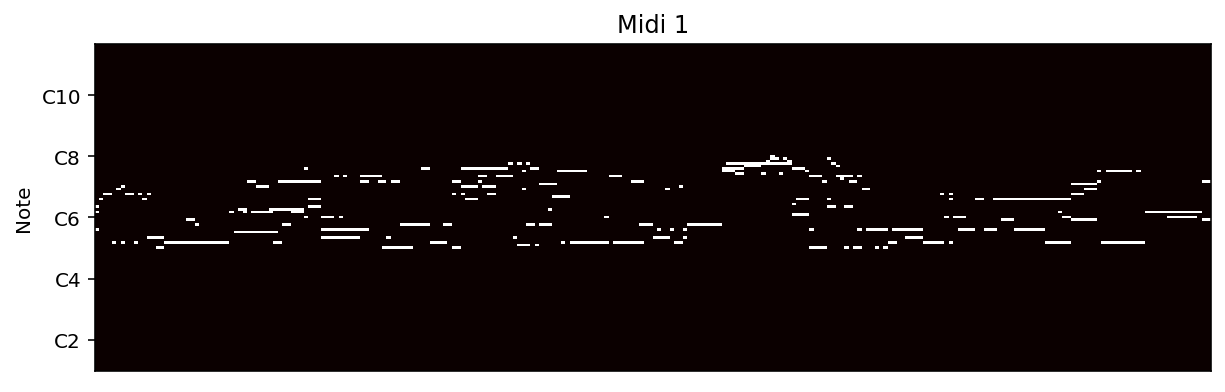

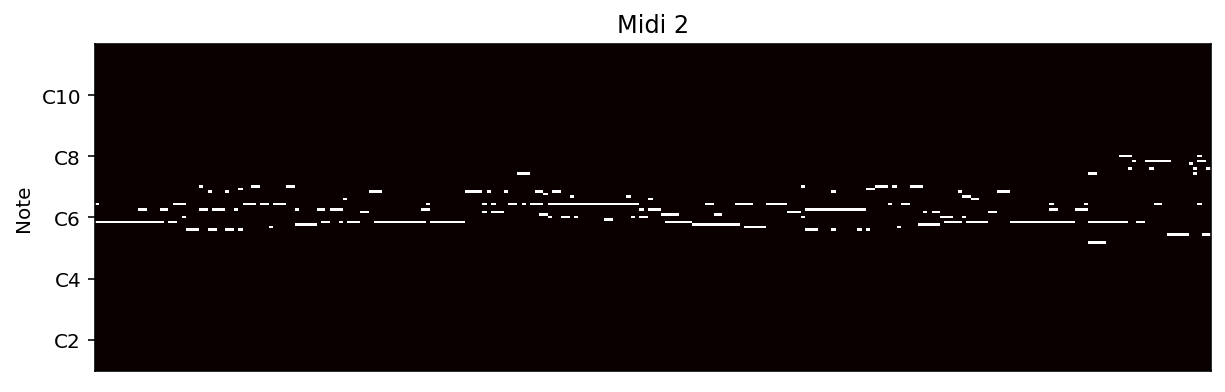

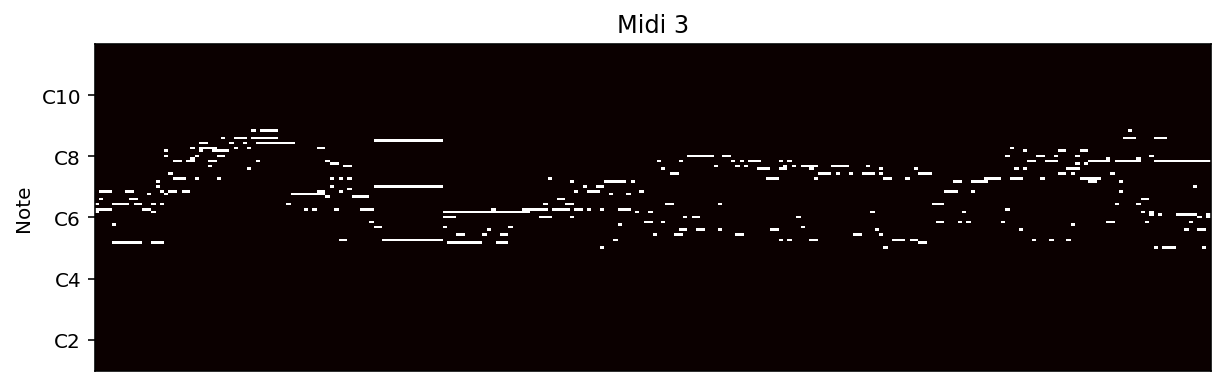

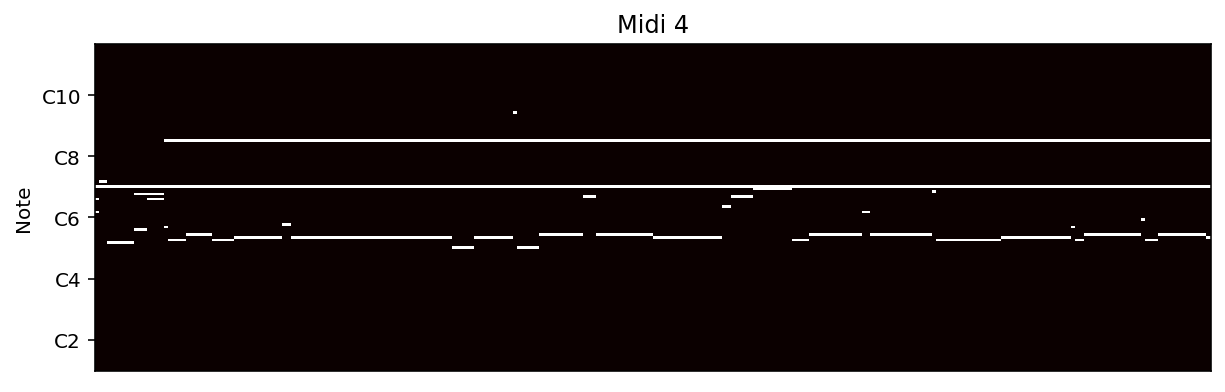

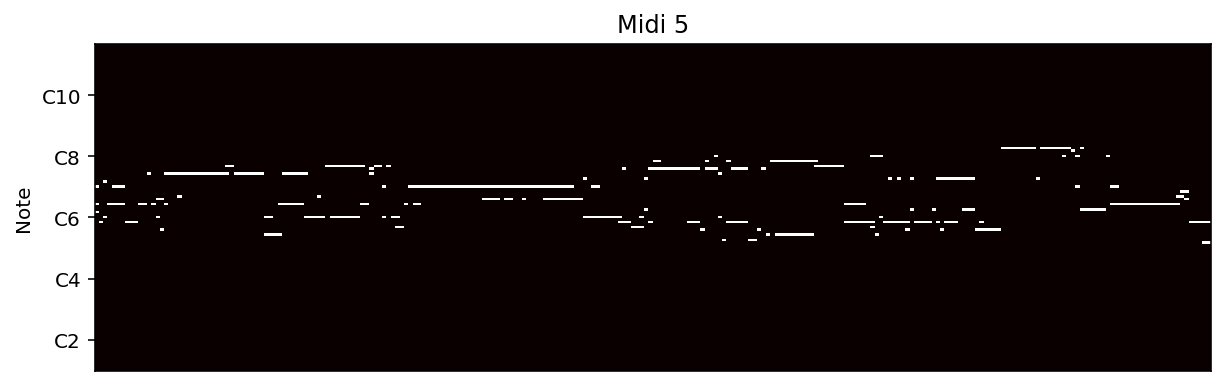

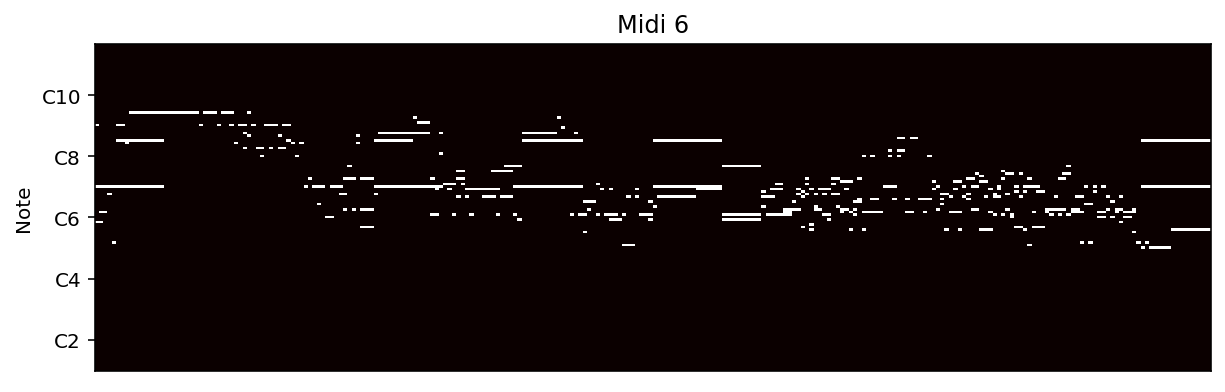

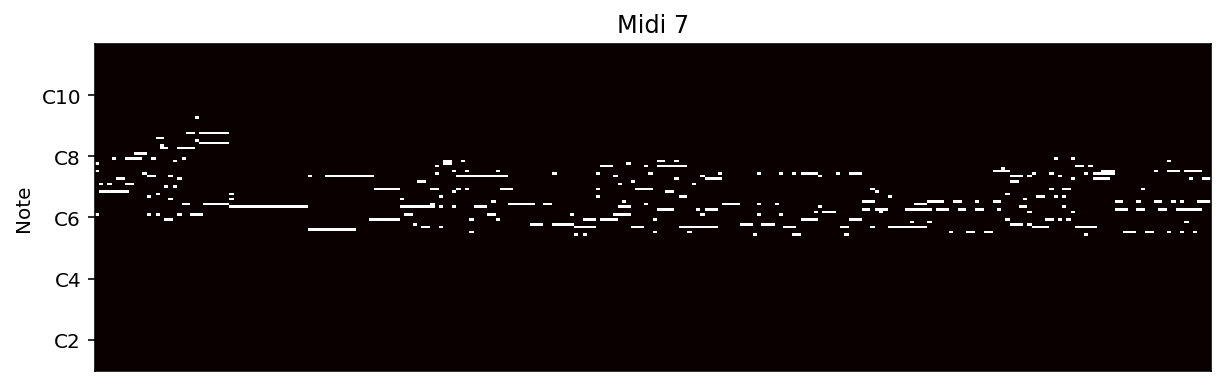

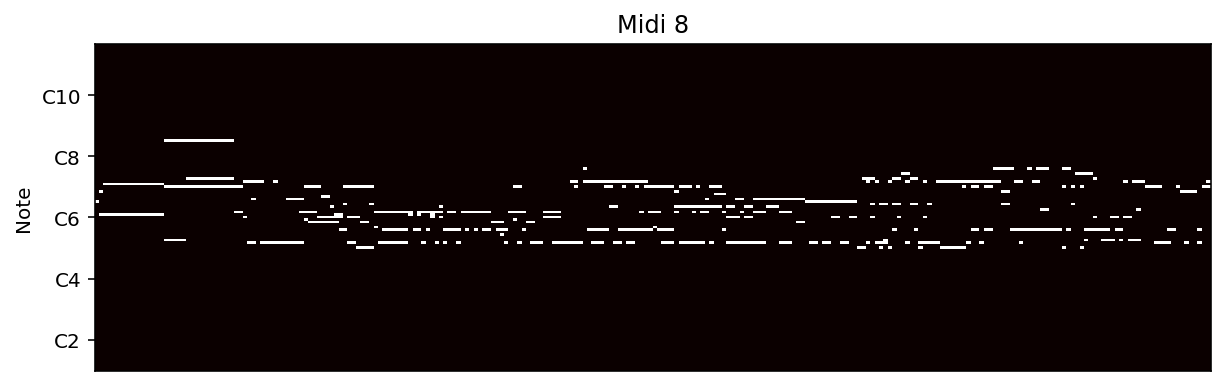

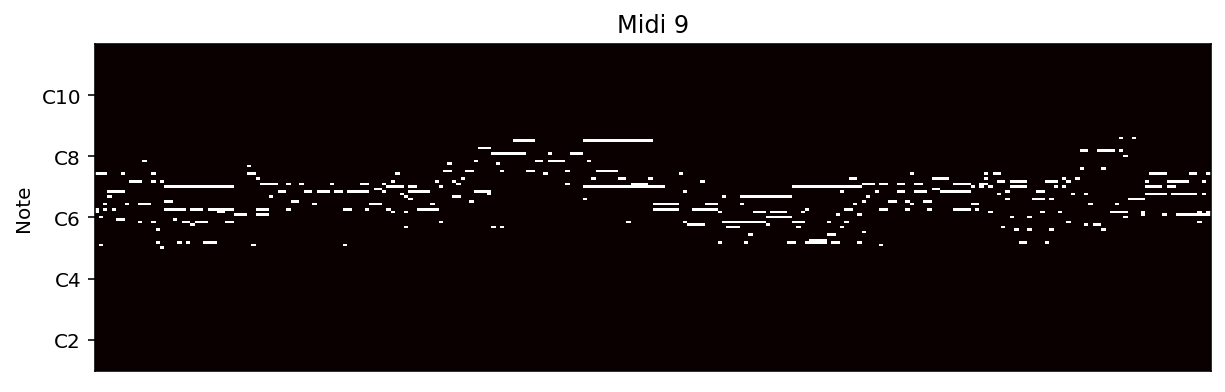

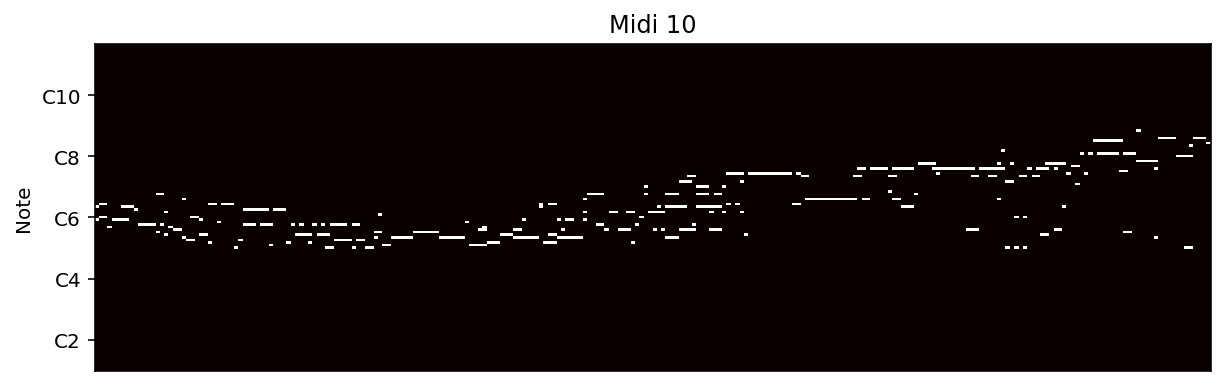

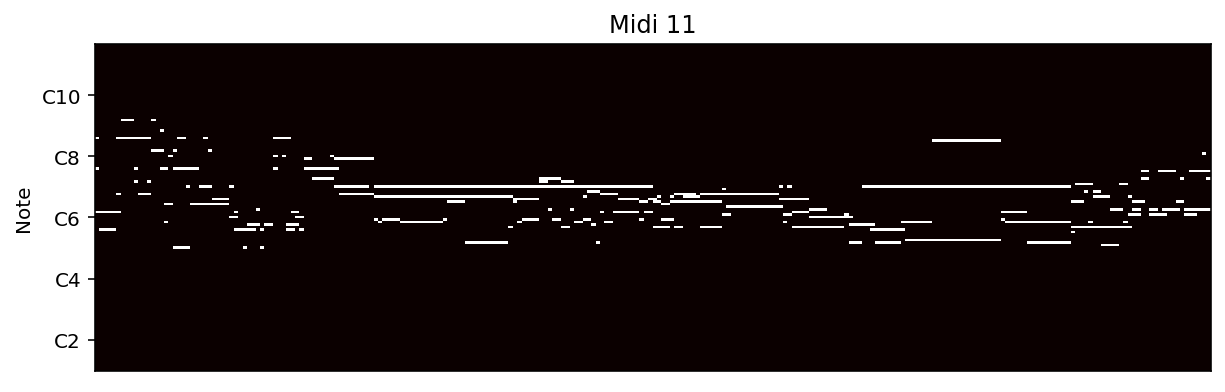

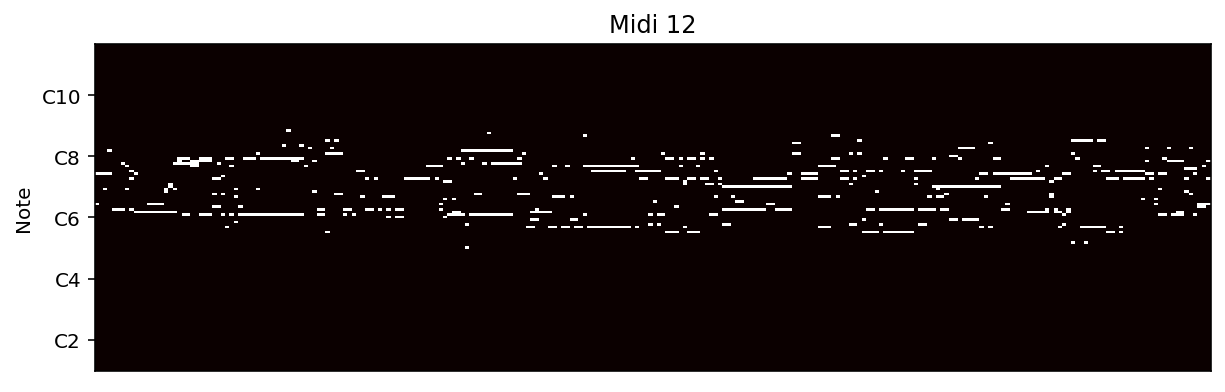

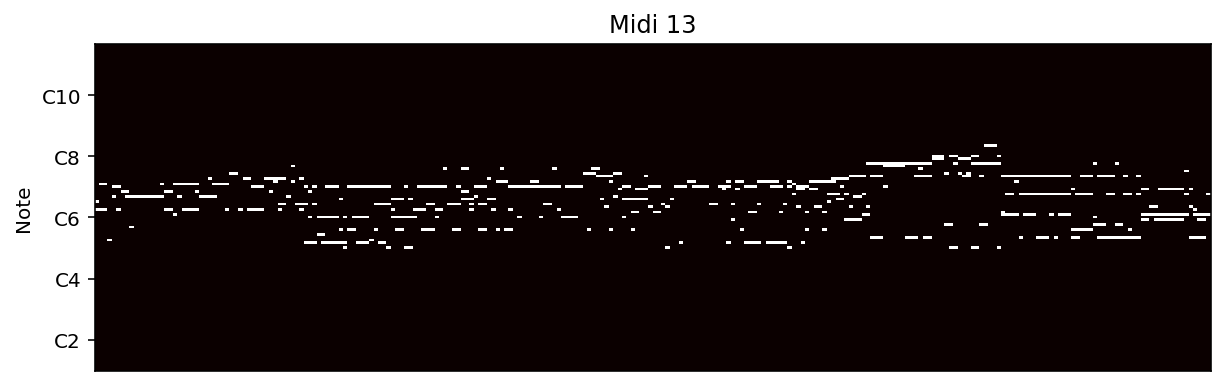

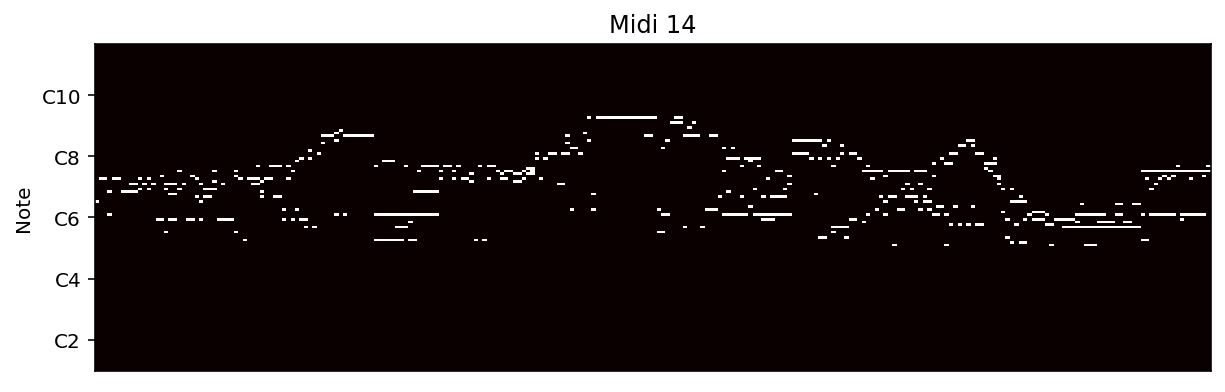

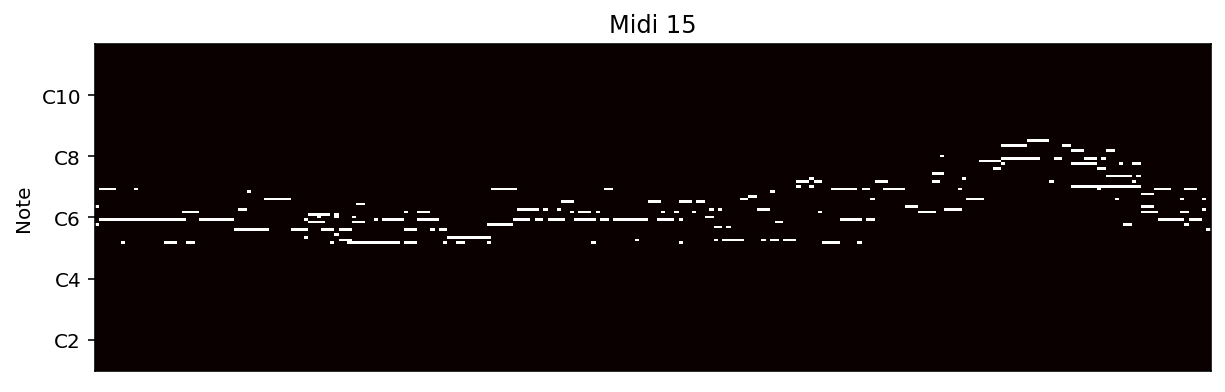

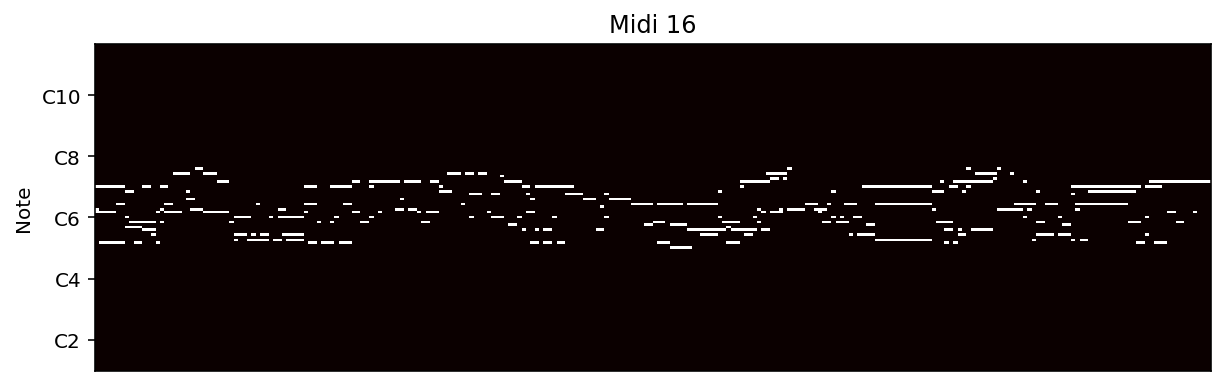

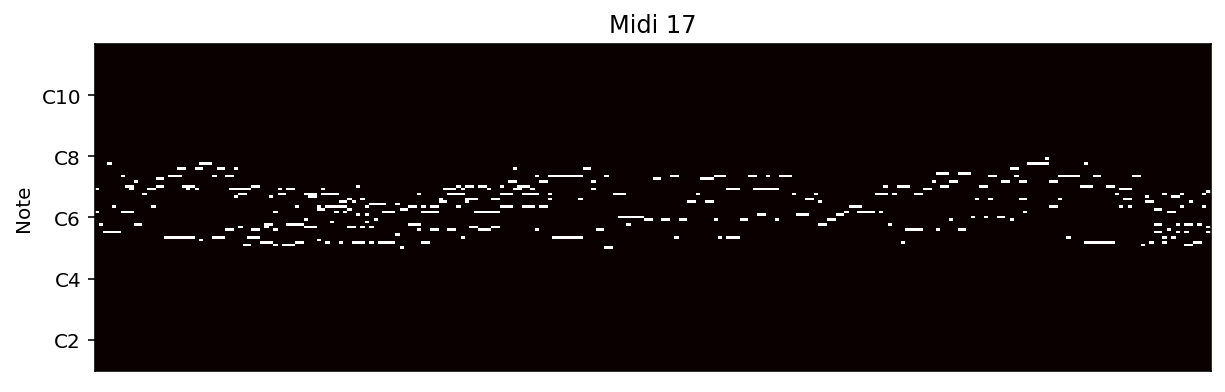

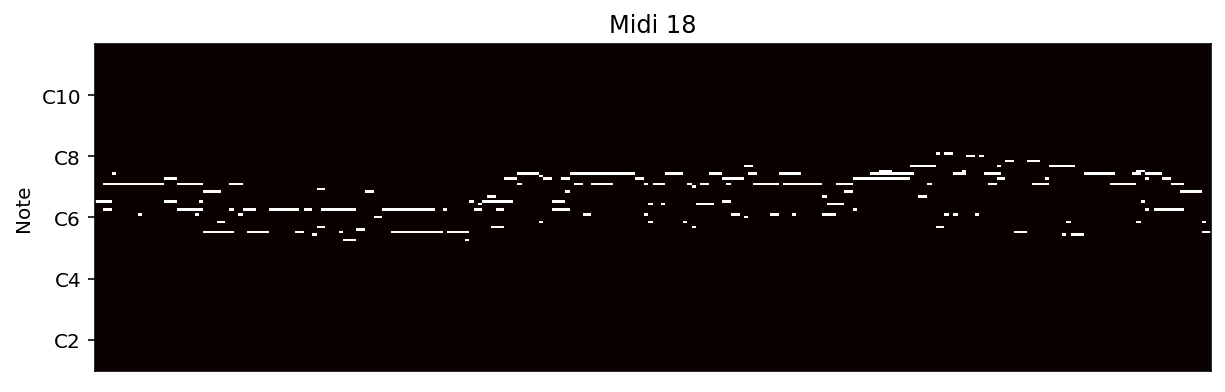

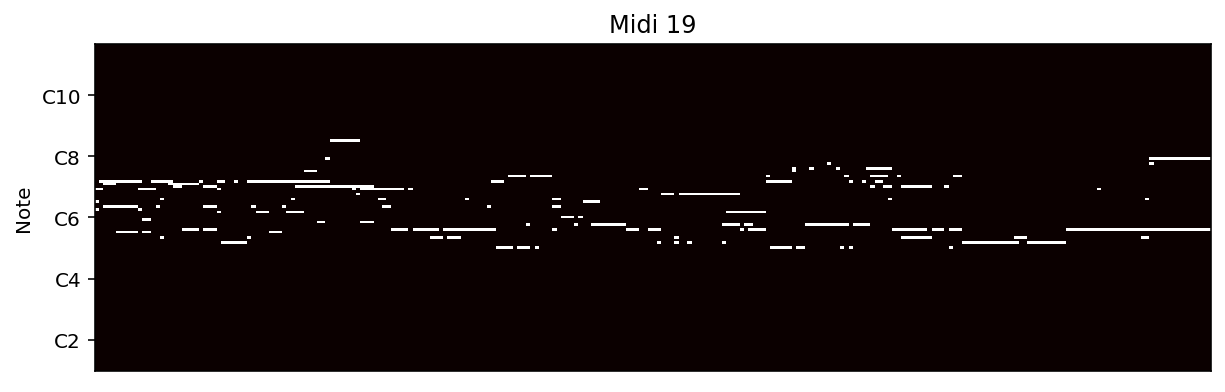

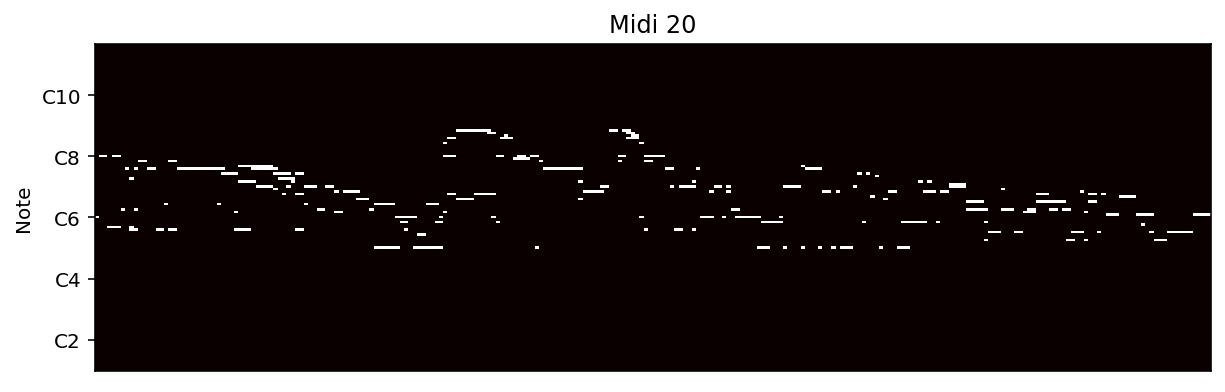

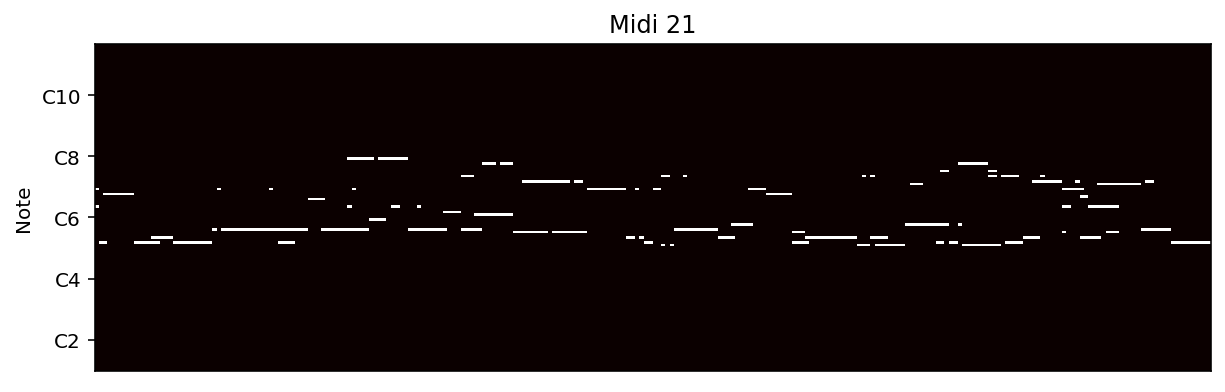

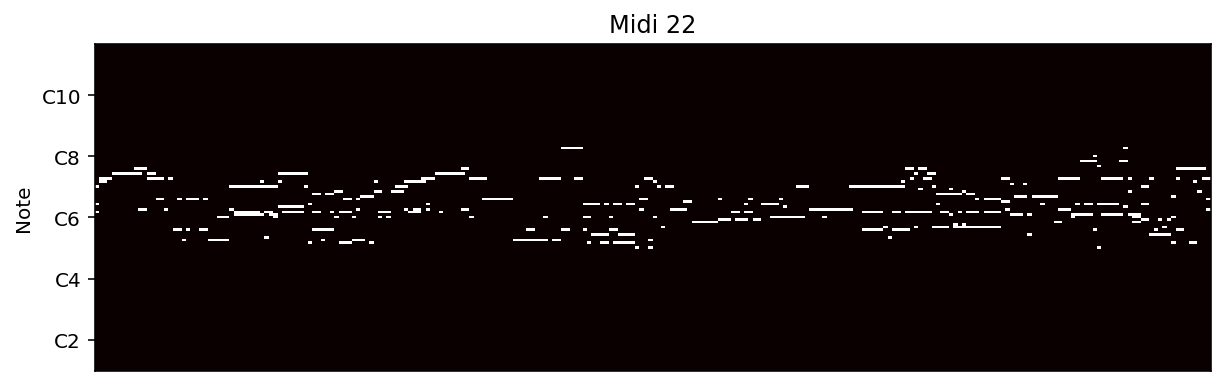

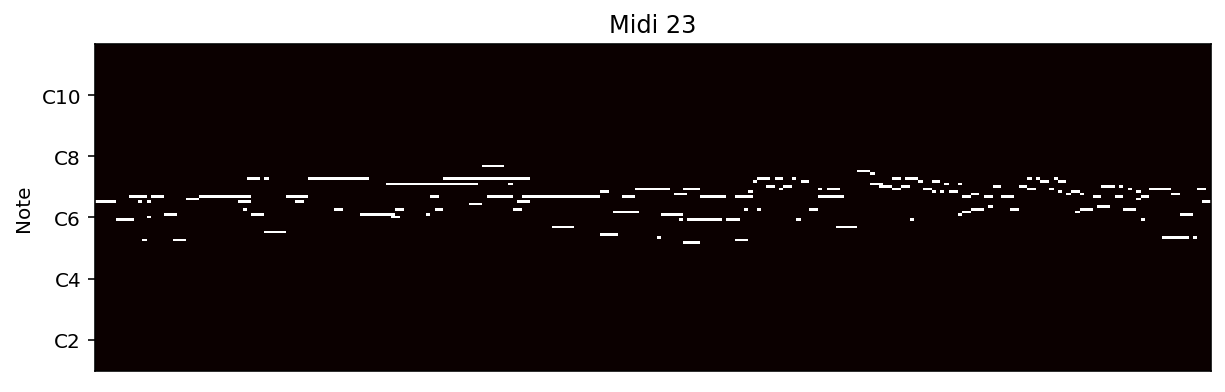

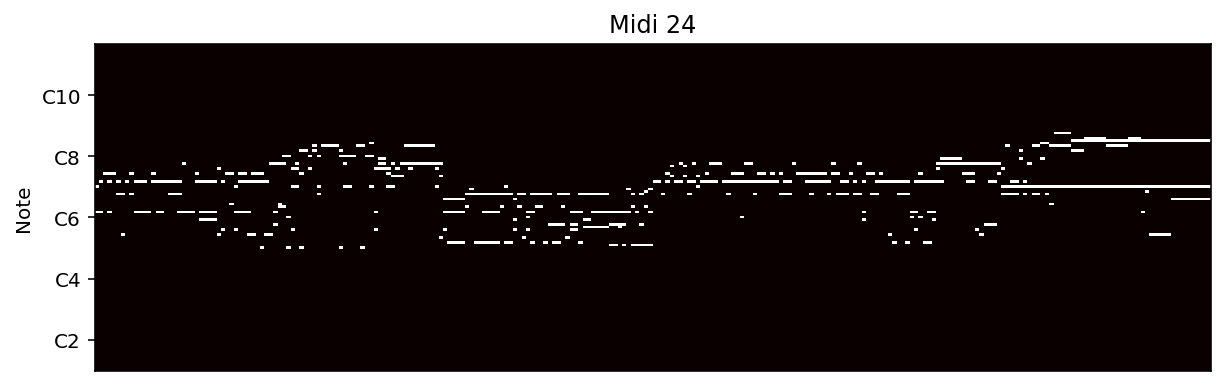

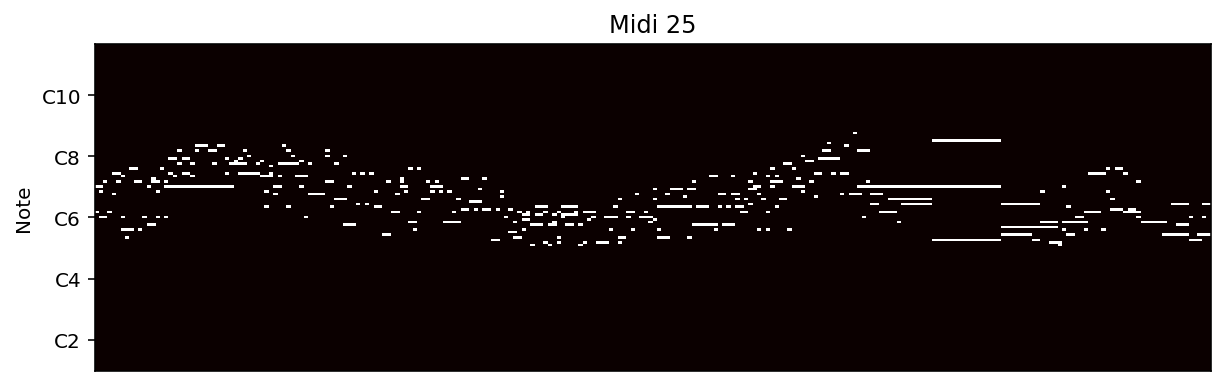

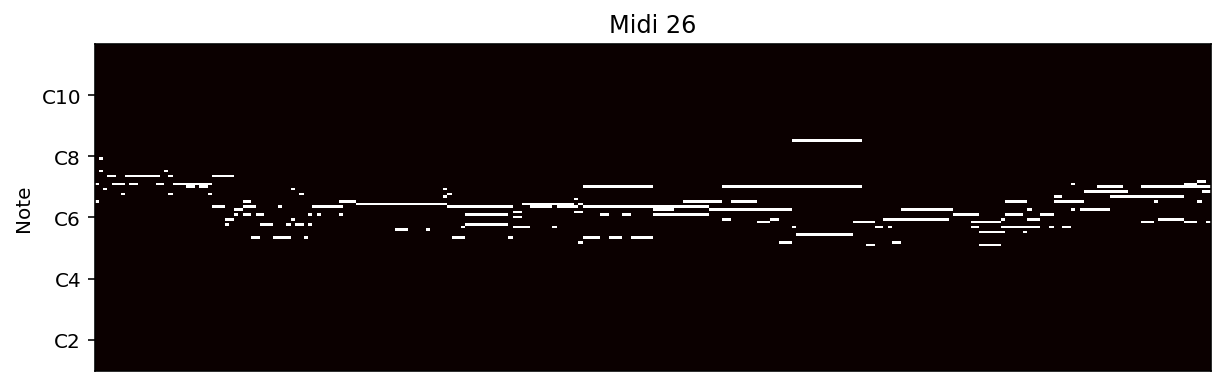

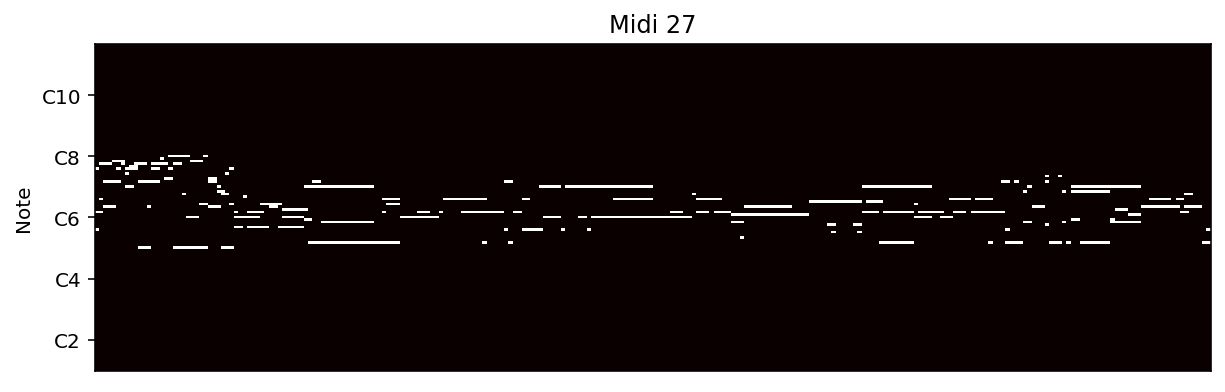

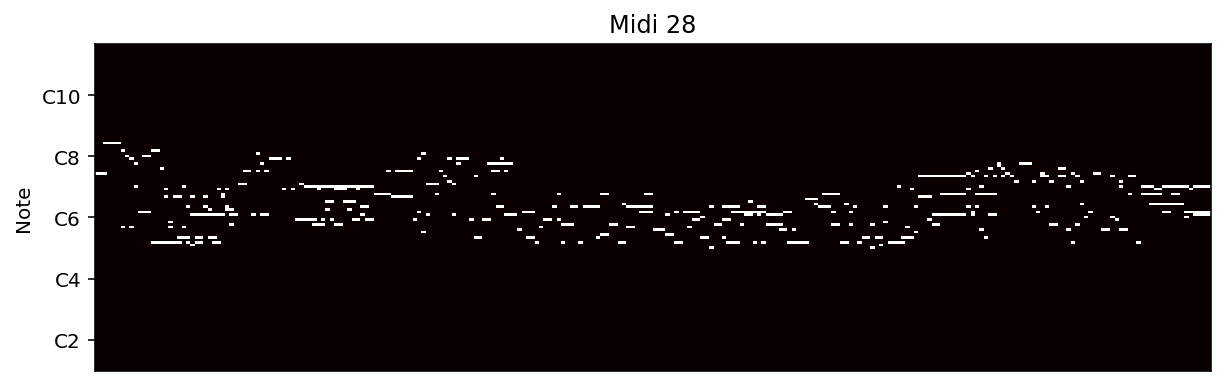

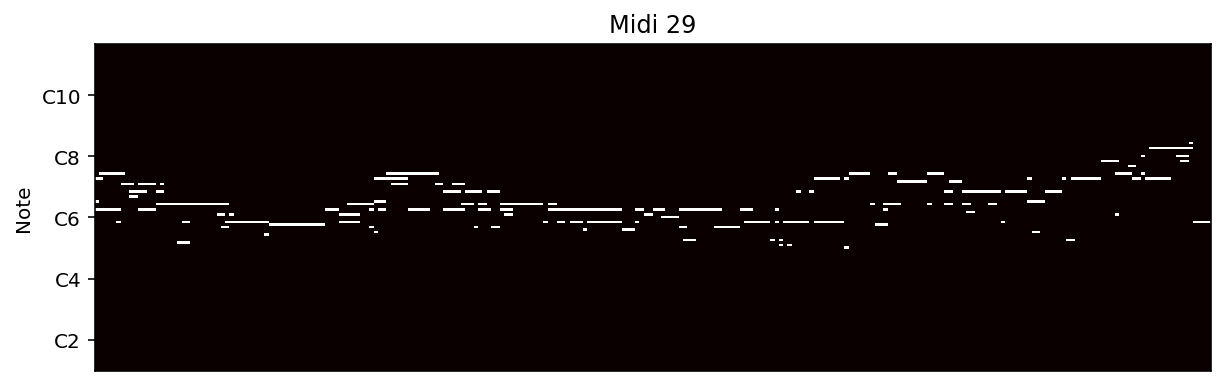

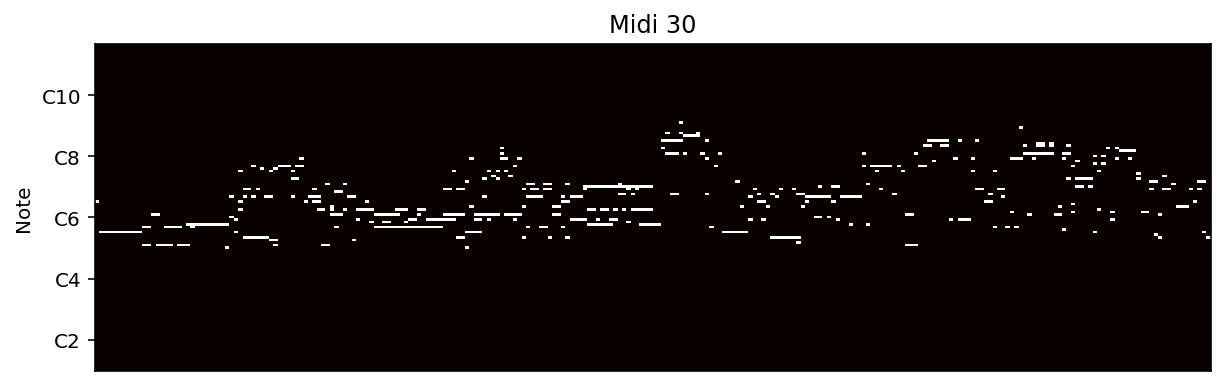

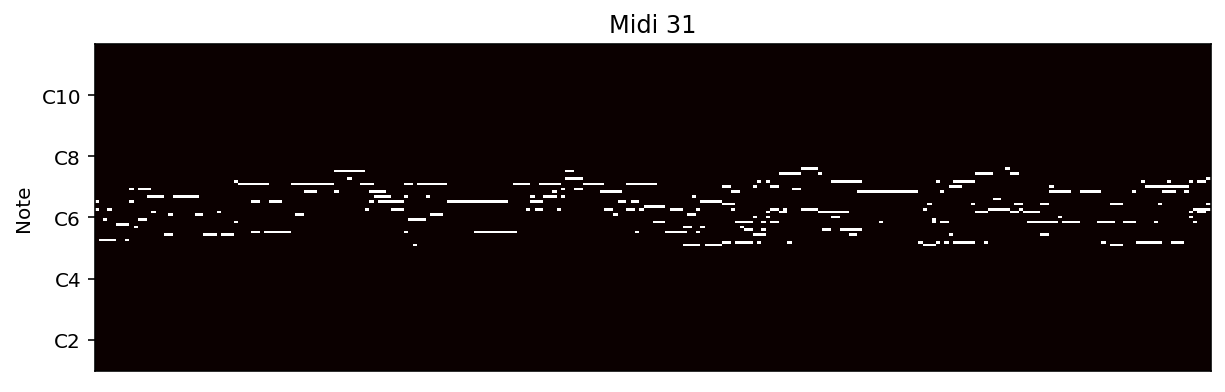

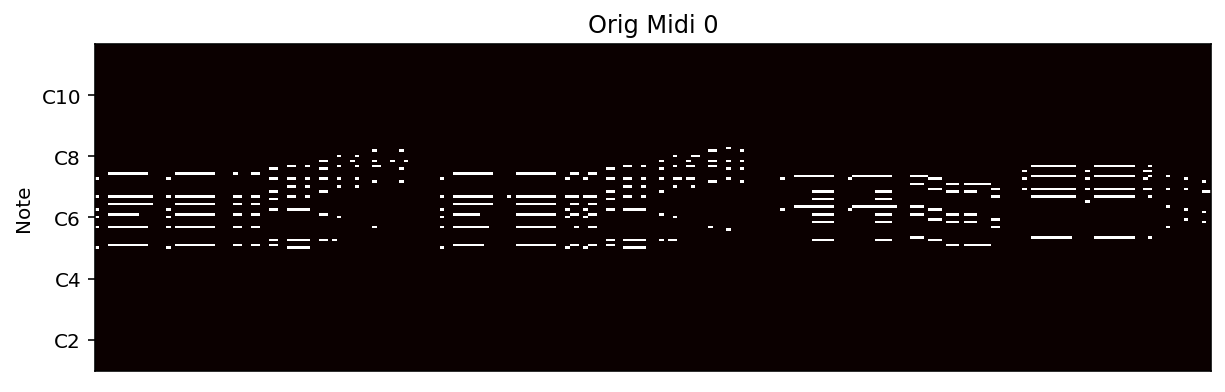

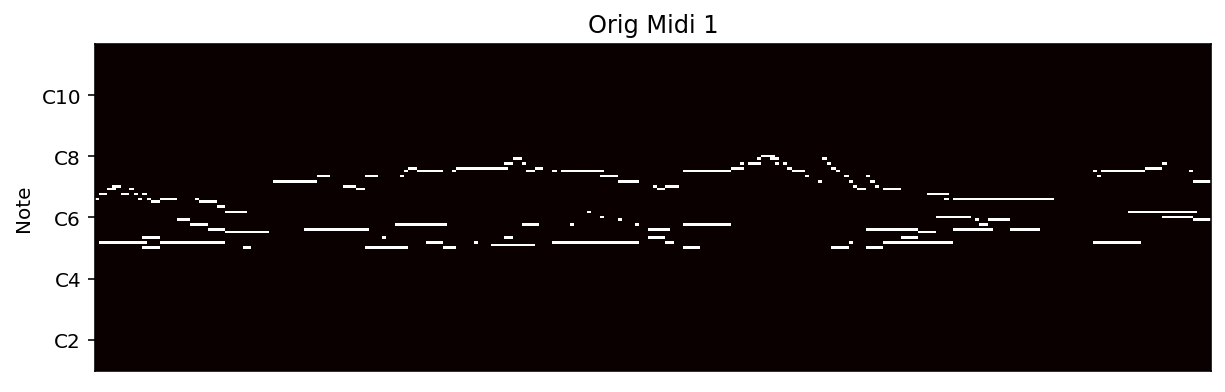

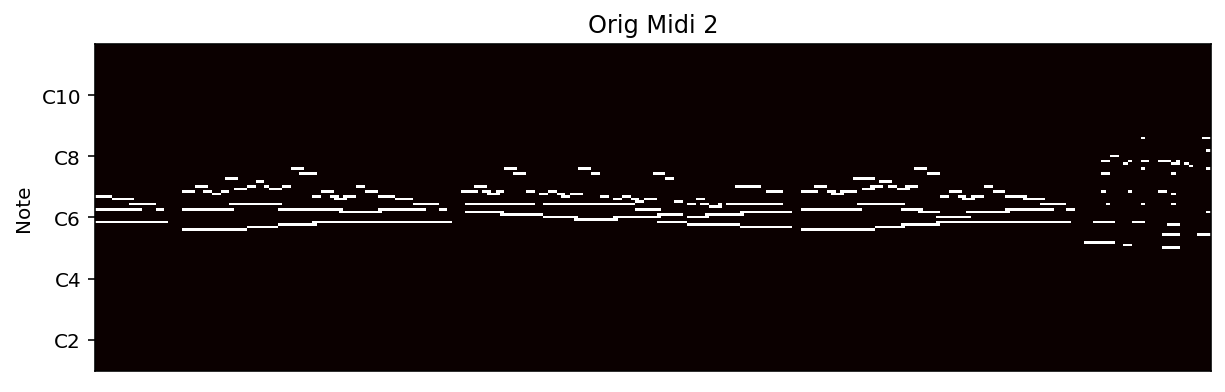

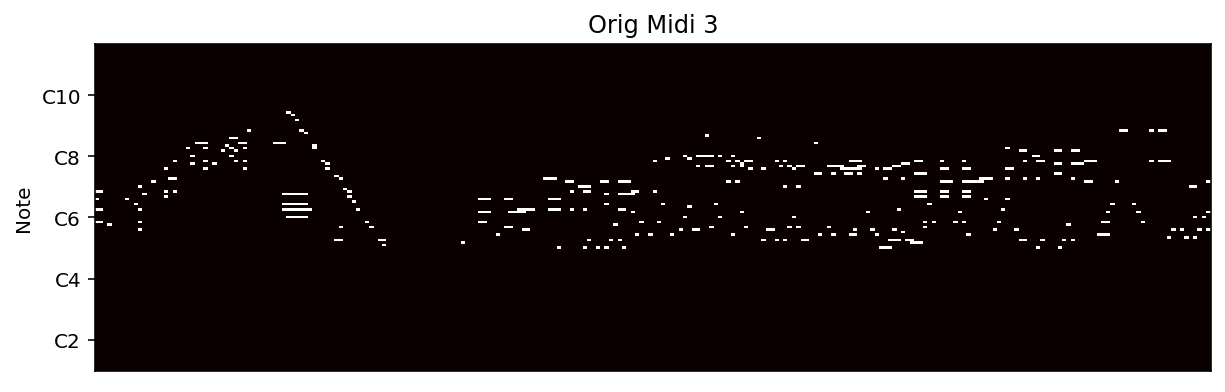

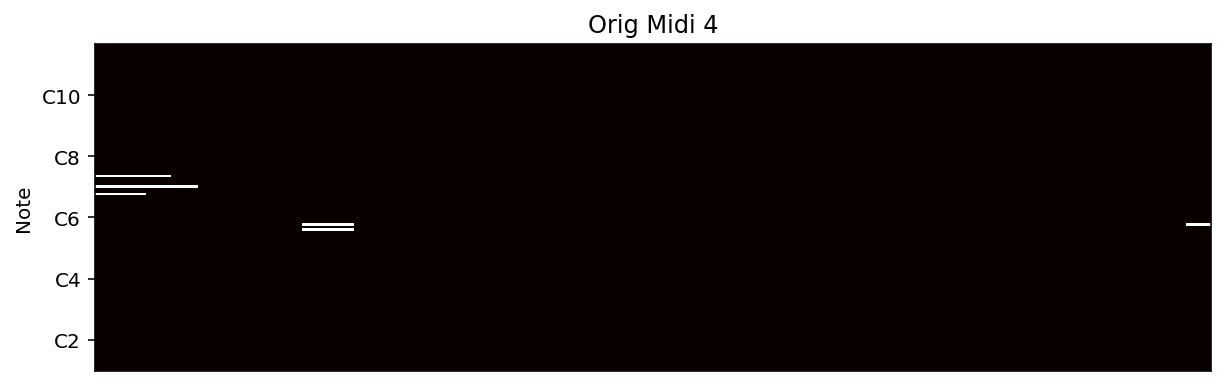

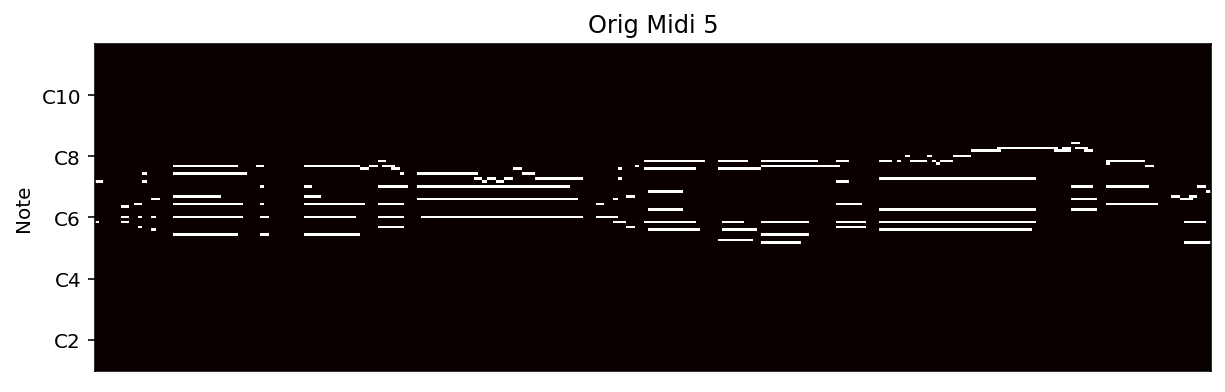

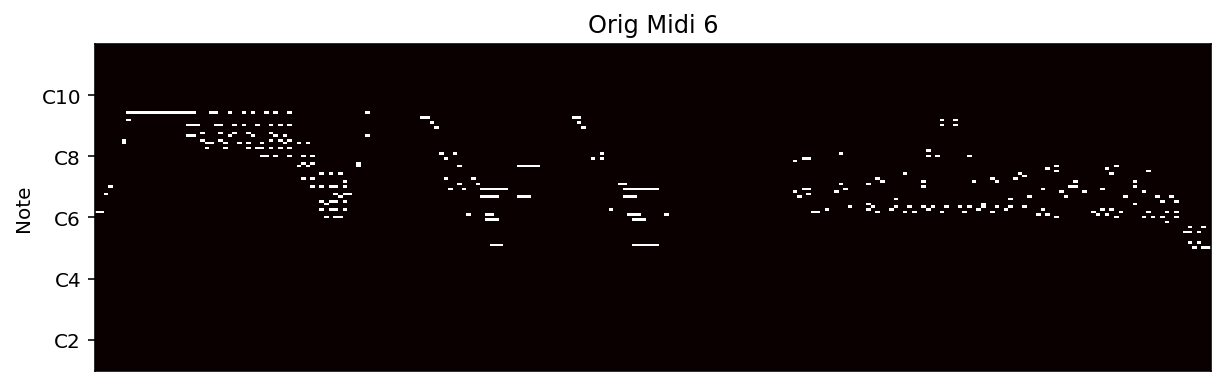

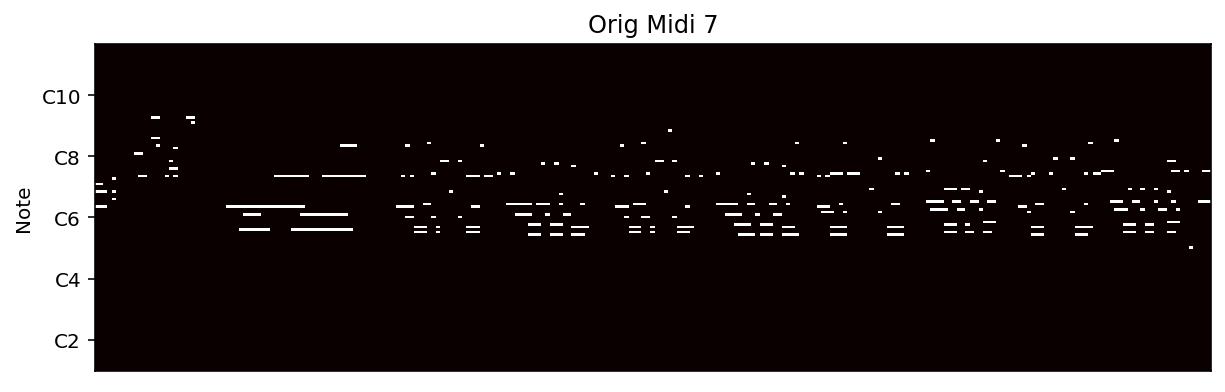

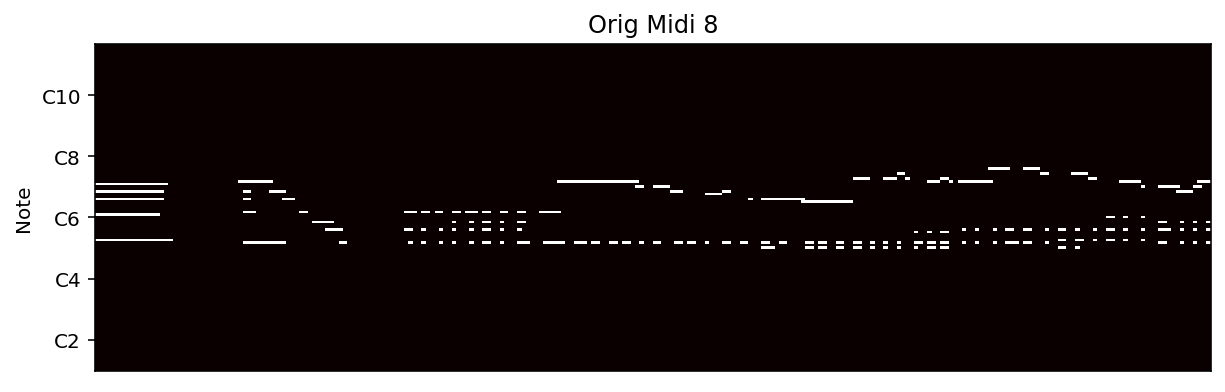

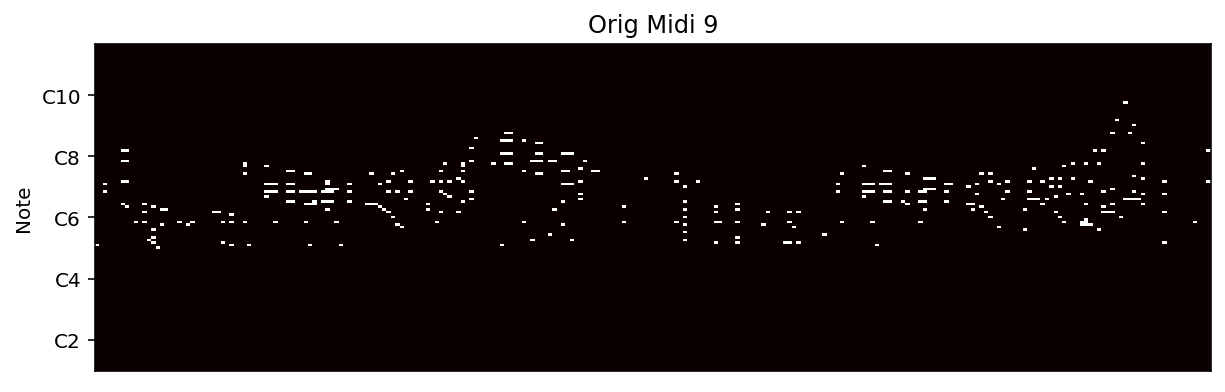

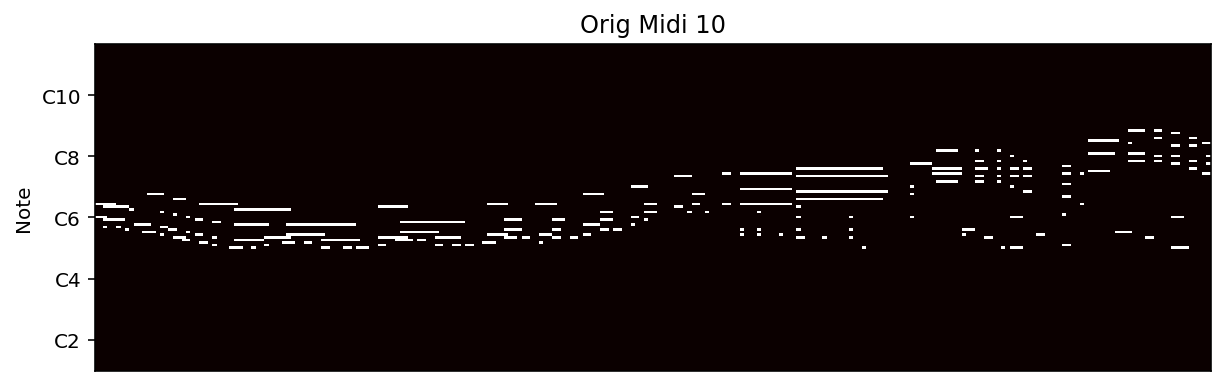

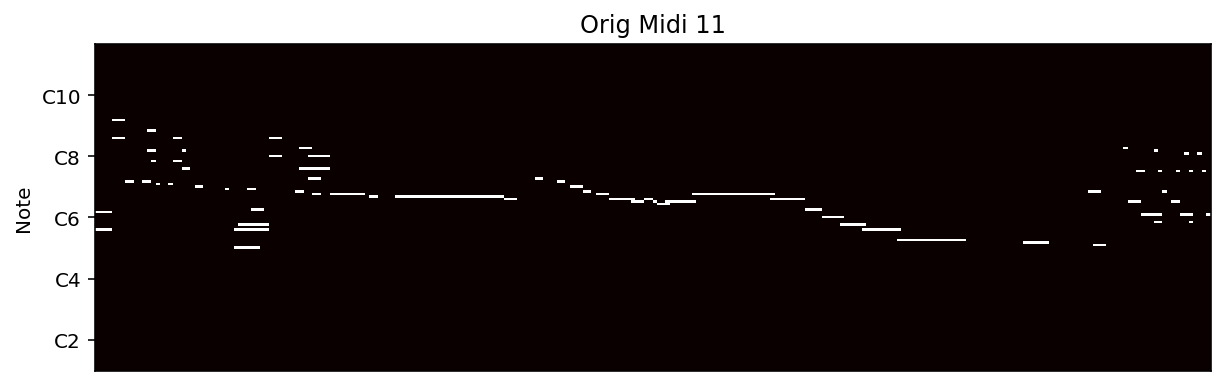

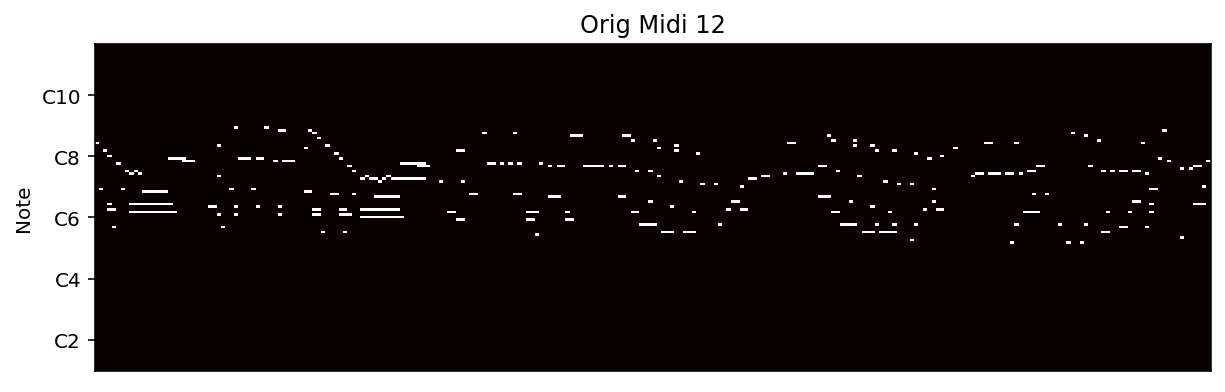

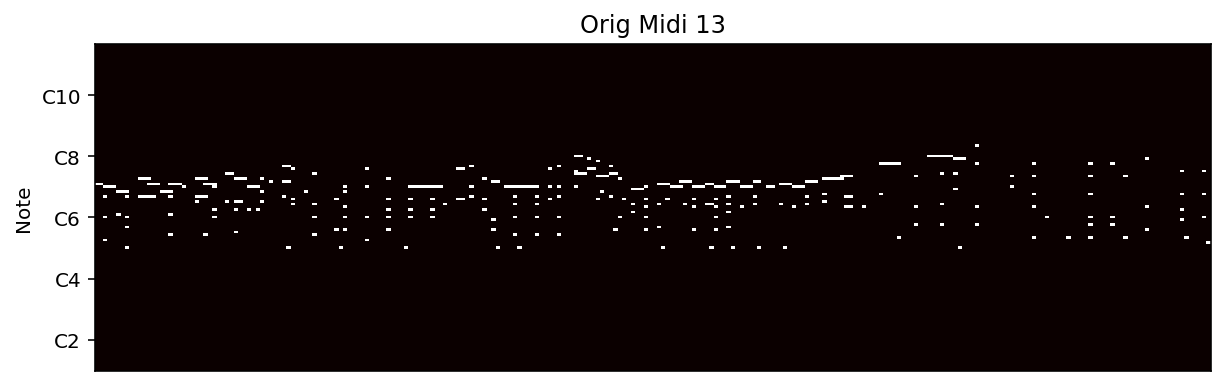

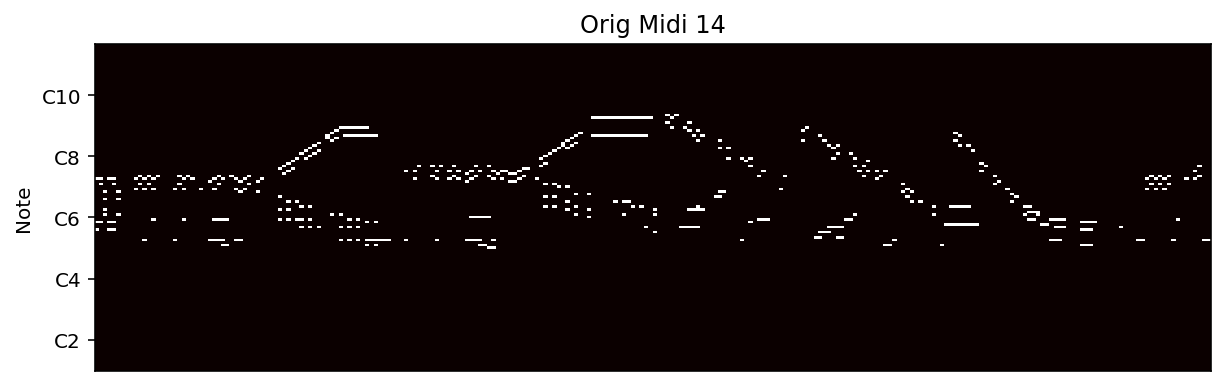

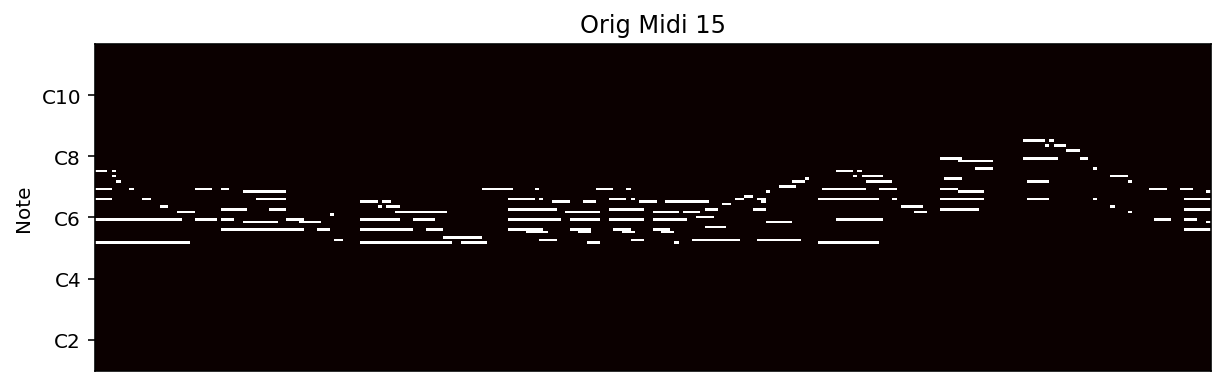

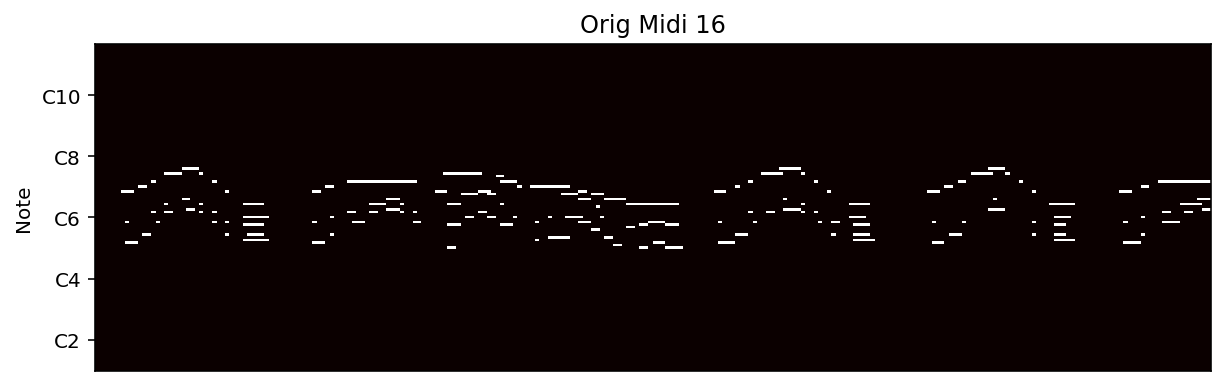

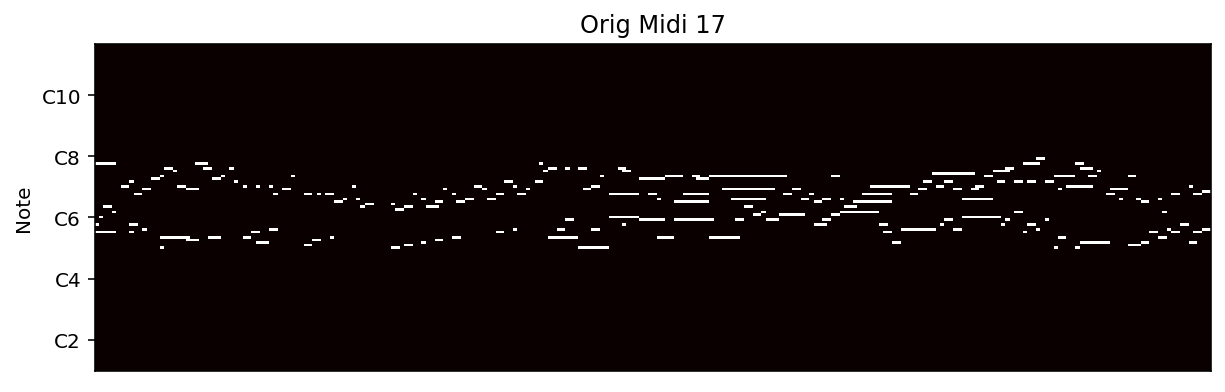

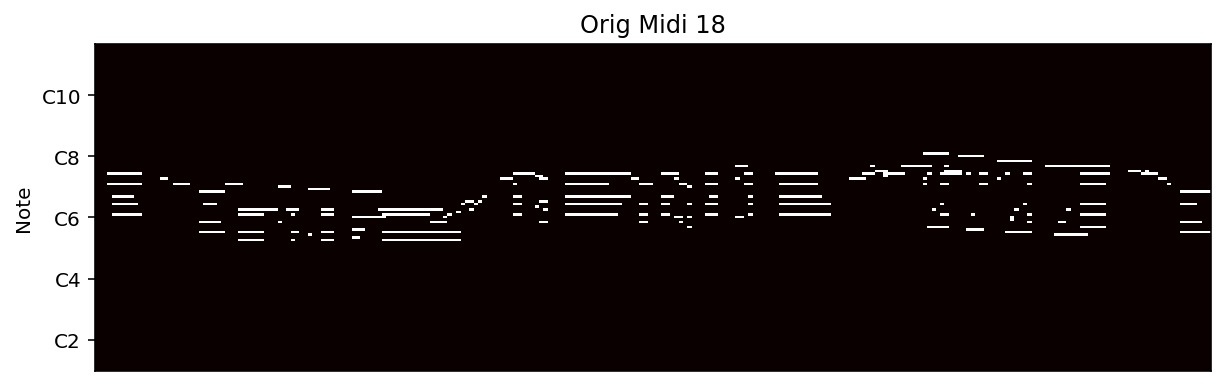

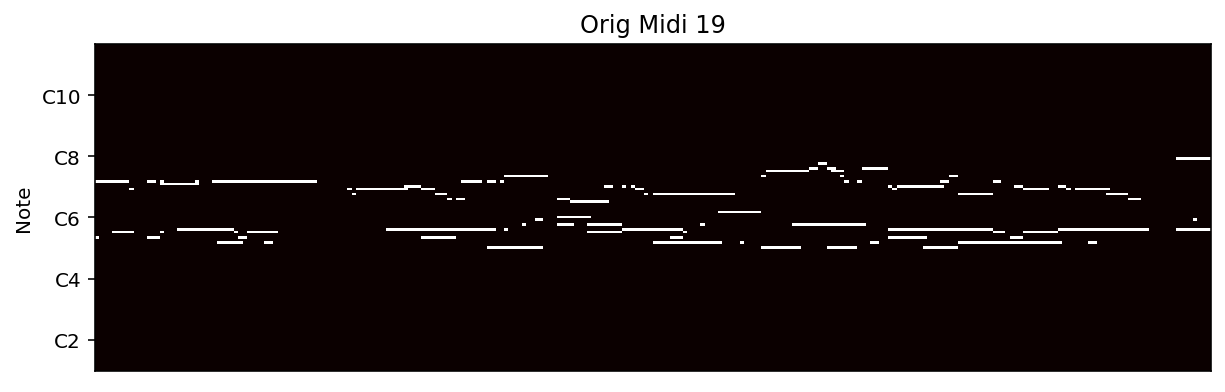

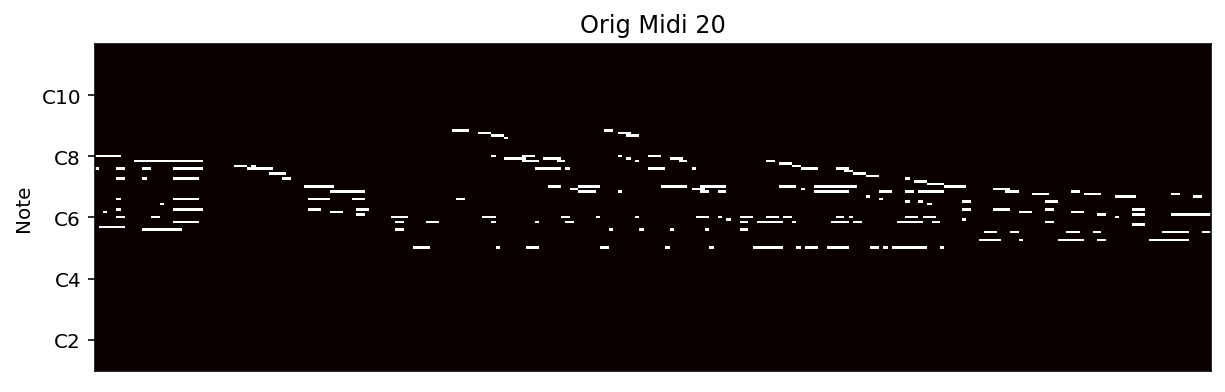

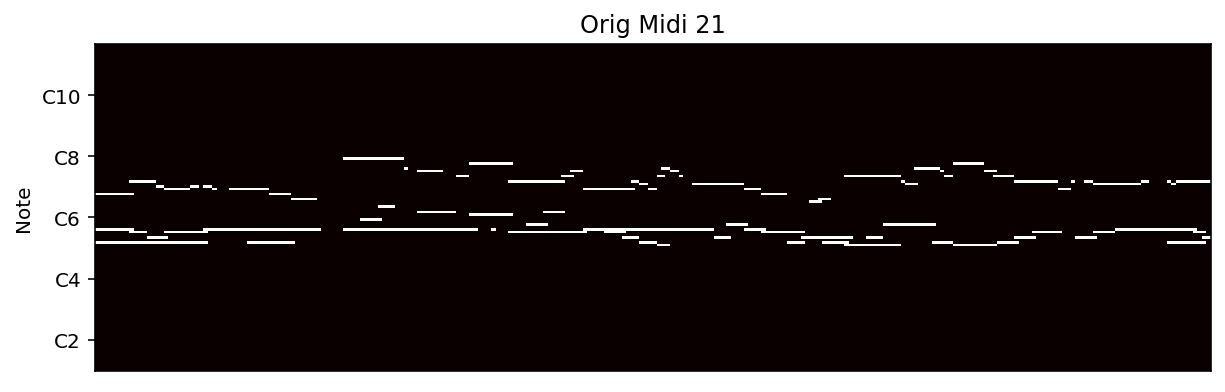

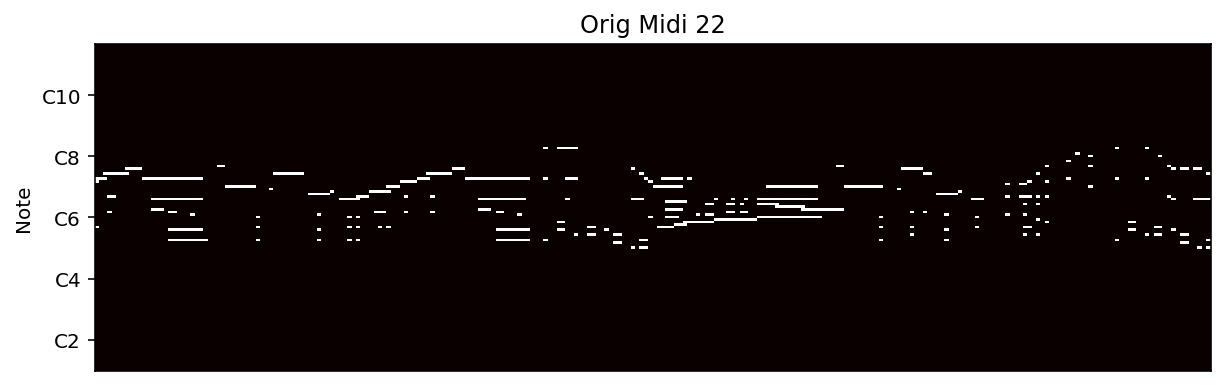

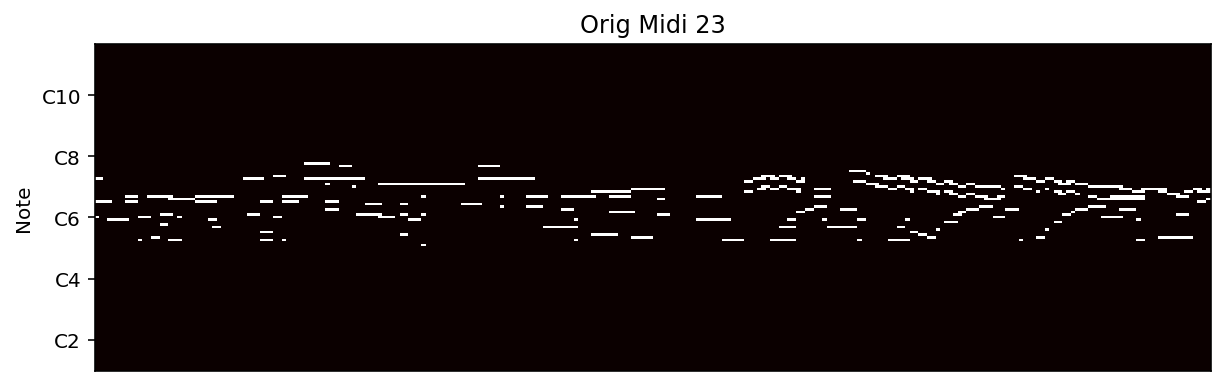

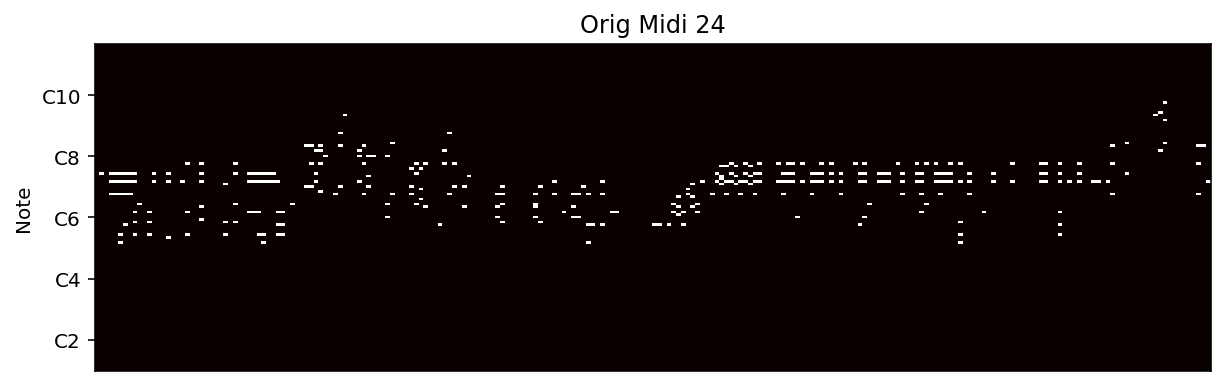

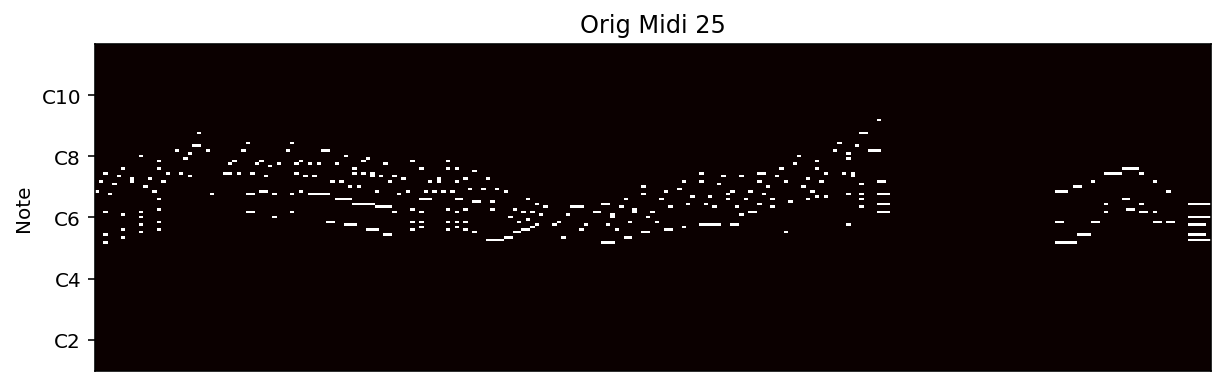

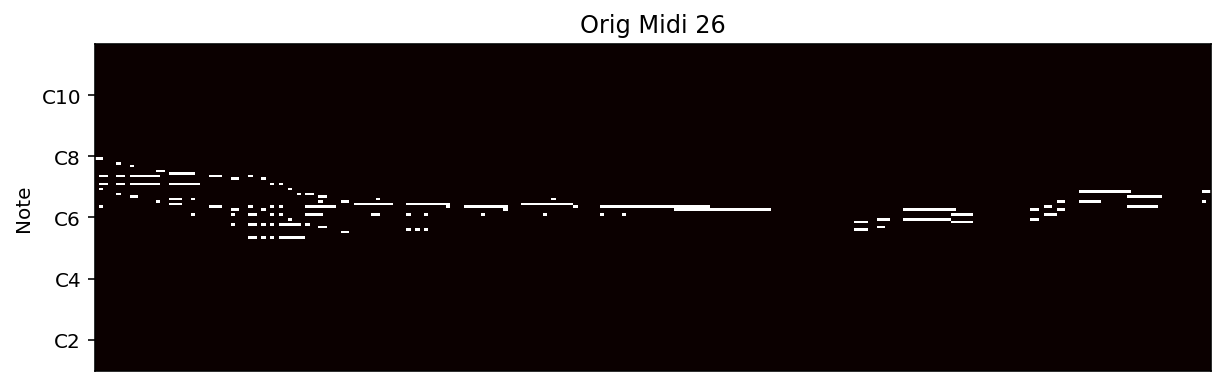

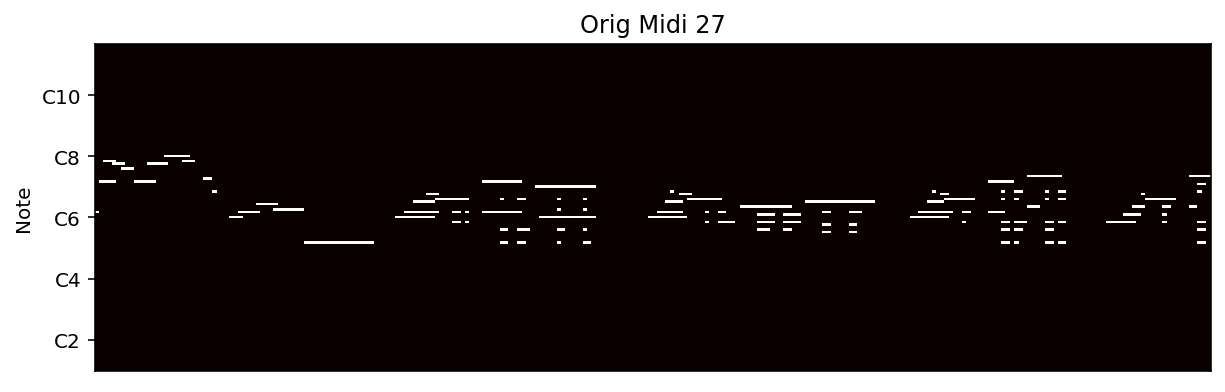

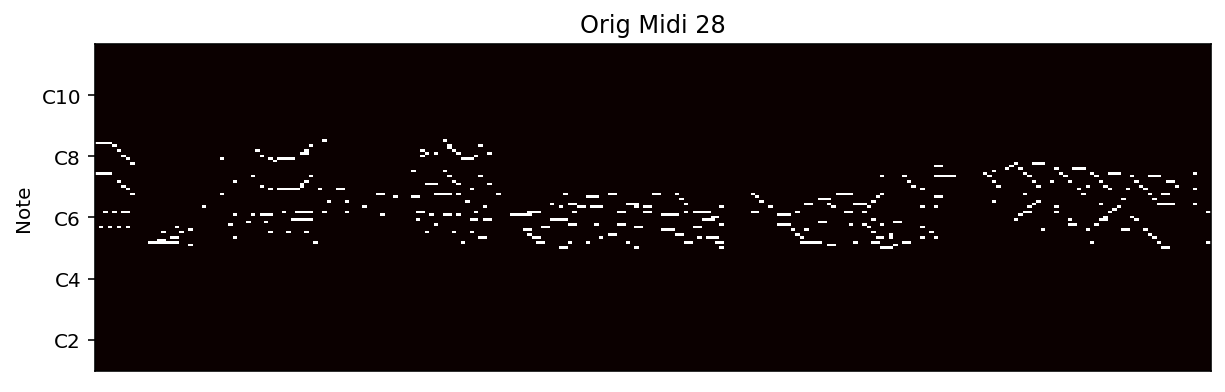

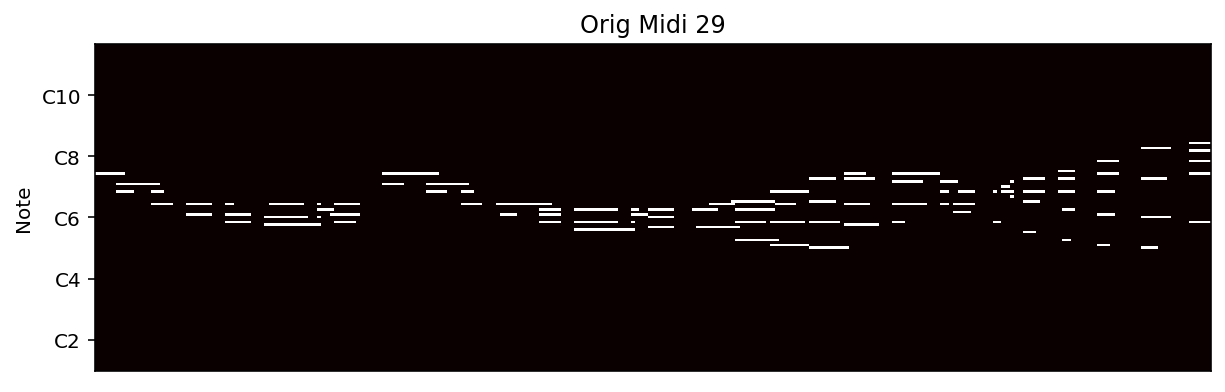

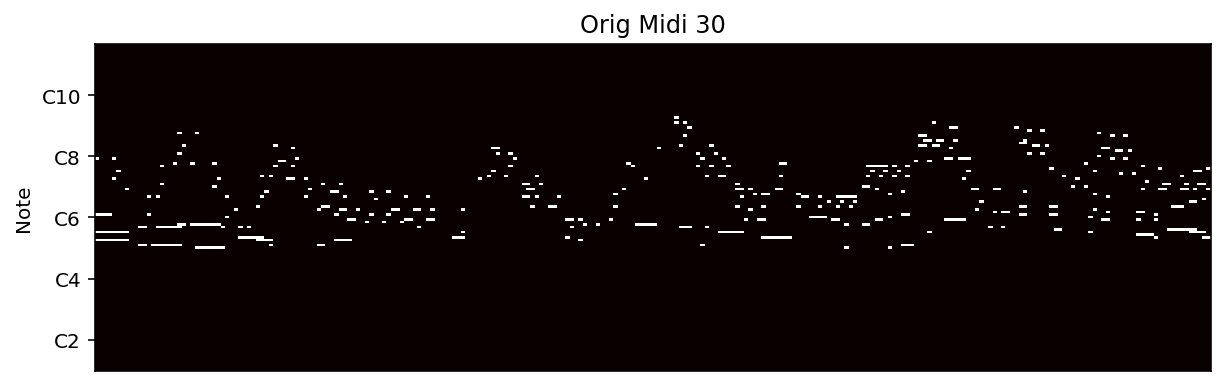

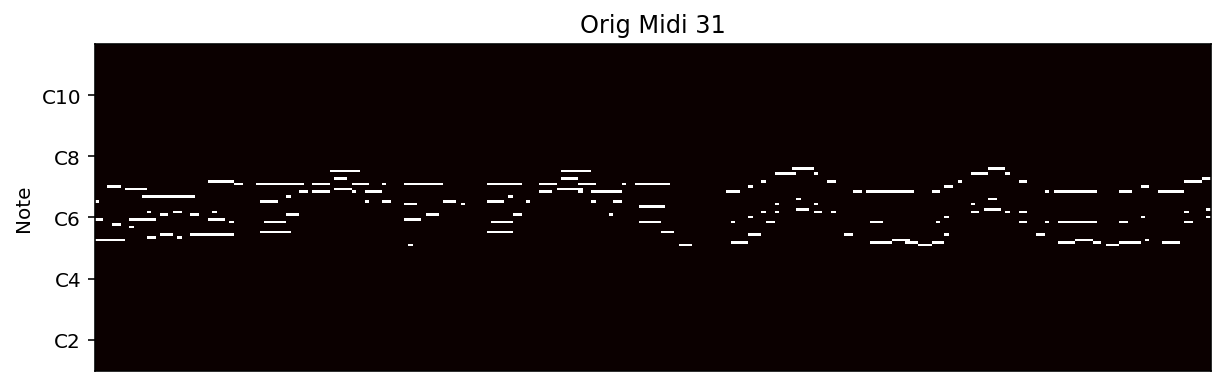

In [25]:
showReconstructionsMultiNotes(x_hat, x)